<a href="https://colab.research.google.com/github/jyjoon001/EEE4178/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

Thu Dec 10 16:15:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#HyperParameters
num_class = 2
in_channel = 1
batch_size = 128
max_pool_kernel = 2
learning_rate = 0.00017
num_epochs = 5

In [ ]:
train_data = torchvision.datasets.EMNIST(root='./datasets',
                                        split='bymerge',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.EMNIST(root='./datasets',
                                        split='bymerge',
                                        train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
train_data.targets[train_data.targets < 11] = 0
train_data.targets[train_data.targets > 10] = 1
print(train_data.targets.unique())

test_data.targets[test_data.targets < 11] = 0
test_data.targets[test_data.targets > 10] = 1
print(test_data.targets.unique())

tensor([0, 1])
tensor([0, 1])


In [ ]:
# Define Model
class ConvNet(nn.Module):
  def __init__(self, num_class):
    super(ConvNet, self).__init__()
    self.layer1a = nn.Sequential(
        nn.Conv2d(1, 6, 3, stride=1, padding=1),
        nn.BatchNorm2d(6),
        nn.ReLU(),
    )
    self.layer1b = nn.Sequential(
        nn.Conv2d(6, 10, 3, stride=1, padding=1),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.layer2a = nn.Sequential(
        nn.Conv2d(10, 16, 5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.layer2b = nn.Sequential(
        nn.Conv2d(16, 32, 5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    self.layer3a = nn.Sequential(
        nn.Conv2d(32, 64, 7, stride=1, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer3b = nn.Sequential(
        nn.Conv2d(64, 128, 7, stride=1, padding=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(6),
        nn.Flatten()
    )
    self.fc0 = nn.Sequential(
        nn.Linear(6*6*128, 360),
        nn.BatchNorm1d(360),
        nn.ReLU()
    )
    self.fc1 = nn.Sequential(
        nn.Linear(360, 120),
        nn.BatchNorm1d(120),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(120, 84),
        nn.BatchNorm1d(84),
        nn.ReLU()
    )
    self.fc3 = nn.Sequential(
        nn.Linear(84, num_class),
        nn.BatchNorm1d(num_class)
    )

  def forward(self, x):
    x = self.layer1a(x)
    x = self.layer1b(x)
    x = self.layer2a(x)
    x = self.layer2b(x)
    x = self.layer3a(x)   
    x = self.layer3b(x)   
    x = x.reshape(x.size(0),-1)
    x = self.fc0(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = F.log_softmax(self.fc3(x))
    return x

model = ConvNet(num_class).to(device)

In [ ]:
model

ConvNet(
  (layer1a): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1b): Sequential(
    (0): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2a): Sequential(
    (0): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2b): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
best_epoch = 0
best_loss = float('inf')
total_step = len(train_loader)
loss_list = []

for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)

    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
end = time.time()
print("Train takes {:.2f}minutes".format((end-start)/60))
torch.save(model.state_dict(),'20161482_model1.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/5], Step[1000/5453], Loss:0.2615
Epoch [1/5], Step[2000/5453], Loss:0.2569
Epoch [1/5], Step[3000/5453], Loss:0.1999
Epoch [1/5], Step[4000/5453], Loss:0.1459
Epoch [1/5], Step[5000/5453], Loss:0.2323
Epoch [2/5], Step[1000/5453], Loss:0.1936
Epoch [2/5], Step[2000/5453], Loss:0.1588
Epoch [2/5], Step[3000/5453], Loss:0.1434
Epoch [2/5], Step[4000/5453], Loss:0.1182
Epoch [2/5], Step[5000/5453], Loss:0.2159
Epoch [3/5], Step[1000/5453], Loss:0.1571
Epoch [3/5], Step[2000/5453], Loss:0.1416
Epoch [3/5], Step[3000/5453], Loss:0.1392
Epoch [3/5], Step[4000/5453], Loss:0.1951
Epoch [3/5], Step[5000/5453], Loss:0.1312
Epoch [4/5], Step[1000/5453], Loss:0.1606
Epoch [4/5], Step[2000/5453], Loss:0.2415
Epoch [4/5], Step[3000/5453], Loss:0.1806
Epoch [4/5], Step[4000/5453], Loss:0.1556
Epoch [4/5], Step[5000/5453], Loss:0.2217
Epoch [5/5], Step[1000/5453], Loss:0.1793
Epoch [5/5], Step[2000/5453], Loss:0.1529
Epoch [5/5], Step[3000/5453], Loss:0.2020
Epoch [5/5], Step[4000/5453], Loss

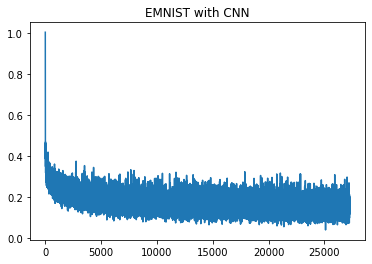

In [ ]:
plt.plot(loss_list)
plt.title("EMNIST with CNN")
plt.show()

In [ ]:
model_saved = ConvNet(num_class).to(device)
model_saved.load_state_dict(torch.load("20161482_model1.pth"))
model_saved.eval()

with torch.no_grad():
  correct = 0
  
  for image, lab in test_loader:
    image = image.to(device)
    lab = lab.to(device)
    out = model_saved(image)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 116352 test images: 92.96789053905391%
